In [1]:
# import keras
import tensorflow as tf
from tensorflow import keras
keras.__version__

'2.10.0'

# Recursive neural networks

[...]

## Recursive layer in the Keras package


The process we implemented using the Numpy library is equivalent to a simple layer called The SimpleRNN of the Keras package:

In [2]:
from keras.layers import SimpleRNN

However, there is a small difference between these implementations: the SimpleRNN layer divides the sequences into batches (this is done by all Keras layers) — it does not process individual sequences as it did in the example implemented with The Numpy library. Therefore, this layer accepts input objects with a shape (input_value, time_steps, entry_characteristics) and not (time_steps, entry_characteristics).

The SimpleRNN layer, like all recursive layers of the Keras package, can be run in two modes: it can return full sequences of consecutive output objects for each step of time (three-dimensional tensors in shape (input_value, time_steps, entry_characteristics)) or only the last output objects of individual input sequences (two-dimensional tensors in shape (time_steps, entry_characteristics)). The selection of the operating mode is made using the return_sequences argument. Let's analyze an example where the SimpleRNN layer is applied, and the output is returned only when processing the last step of time:

In [3]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [4]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


Sometimes it's a good idea to create a stack of several recursive layers. This increases the power of representation by the network. With this configuration, all intermediate layers must return the full sequence of output objects:

In [5]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # The last layer returns only the last output object.
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                2080      
                                                                 
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now let's use such a model to solve the problem of rating movie reviews. Let's start with the pre-processing of data:

In [6]:
# !pip install keras
# !pip install tensorflow

In [7]:
from keras.datasets import imdb
from keras_preprocessing.sequence import pad_sequences

max_features = 10000  # The number of words treated as characteristics.
maxlen = 500  # Cuts reviews after this number of words belonging to the set of max_features words most common in the set.
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'training sequences')
print(len(input_test), 'test sequences')

print('Sequences (samples x time)')
input_train = pad_sequences(input_train, maxlen=maxlen)
input_test = pad_sequences(input_test, maxlen=maxlen)
print('Shape of the object input_train:', input_train.shape)
print('Shape of the object input_test:', input_test.shape)


Loading data...
25000 training sequences
25000 test sequences
Sequences (samples x time)
Shape of the object input_train: (25000, 500)
Shape of the object input_test: (25000, 500)


In [8]:
# Visualizing the data that is going to be used
imdb.load_data(num_words=max_features)[0][0][:5]

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 8255, 78, 228,

Let's train a simple recursive network using the Embedding layer and the SimpleRNN layer.

In [9]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 15s 87ms/step - loss: 0.6534 - acc: 0.6033 - val_loss: 0.5412 - val_acc: 0.7598
Epoch 2/10
157/157 [==============================] - 15s 94ms/step - loss: 0.4121 - acc: 0.8230 - val_loss: 0.3707 - val_acc: 0.8488
Epoch 3/10
157/157 [==============================] - 13s 81ms/step - loss: 0.2920 - acc: 0.8830 - val_loss: 0.3729 - val_acc: 0.8390
Epoch 4/10
157/157 [==============================] - 13s 84ms/step - loss: 0.2305 - acc: 0.9111 - val_loss: 0.4430 - val_acc: 0.7934
Epoch 5/10
157/157 [==============================] - 13s 82ms/step - loss: 0.1553 - acc: 0.9456 - val_loss: 0.4408 - val_acc: 0.8522
Epoch 6/10
157/157 [==============================] - 13s 84ms/step - loss: 0.1006 - acc: 0.9654 - val_loss: 0.5914 - val_acc: 0.7652
Epoch 7/10
157/157 [==============================] - 13s 82ms/step - loss: 0.0592 - acc: 0.9826 - val_loss: 0.5199 - val_acc: 0.8292
Epoch 8/10
157/157 [==============================] - 14s 86ms

Now we can view the accuracy graphs and losses in the training and validation processes:

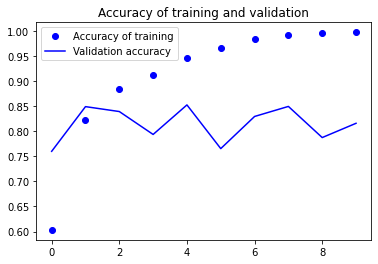

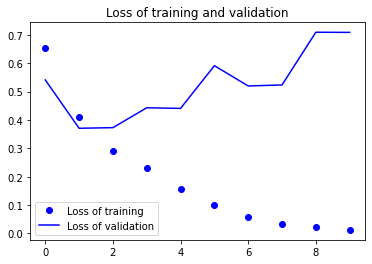

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Accuracy of training')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Accuracy of training and validation')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Loss of training')
plt.plot(epochs, val_loss, 'b', label='Loss of validation')
plt.title('Loss of training and validation')
plt.legend()

plt.show()

[...]

## Example of a LSTM layer implemented in Keras

It's time to look at a practical example of how to use the LSTM layer. We will configure the model in which such a layer will be located and train it on the IMDB dataset. It resembles the previously presented model with the SimpleRNN layer. We will specify only the number of dimensions of the LSTM output object. The remaining arguments of this layer (there are many) will be left with the default values. The default settings of the Keras package are well thought out and usually "just work" without having to spend a lot of time manually tuning the parameters.

In [13]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 42s 240ms/step - loss: 0.4983 - acc: 0.7646 - val_loss: 0.3193 - val_acc: 0.8760
Epoch 2/10
157/157 [==============================] - 37s 235ms/step - loss: 0.2905 - acc: 0.8855 - val_loss: 0.8050 - val_acc: 0.7354
Epoch 3/10
157/157 [==============================] - 37s 234ms/step - loss: 0.2378 - acc: 0.9096 - val_loss: 0.3026 - val_acc: 0.8836
Epoch 4/10
157/157 [==============================] - 37s 238ms/step - loss: 0.2012 - acc: 0.9258 - val_loss: 0.3266 - val_acc: 0.8616
Epoch 5/10
157/157 [==============================] - 38s 243ms/step - loss: 0.1798 - acc: 0.9367 - val_loss: 0.3487 - val_acc: 0.8804
Epoch 6/10
157/157 [==============================] - 41s 262ms/step - loss: 0.1591 - acc: 0.9433 - val_loss: 0.3153 - val_acc: 0.8718
Epoch 7/10
157/157 [==============================] - 37s 237ms/step - loss: 0.1470 - acc: 0.9470 - val_loss: 0.3012 - val_acc: 0.8744
Epoch 8/10
157/157 [==============================] - 3

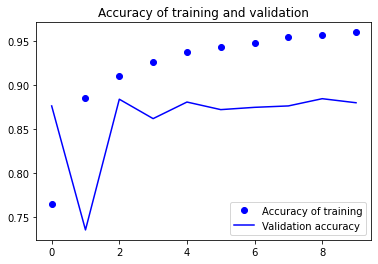

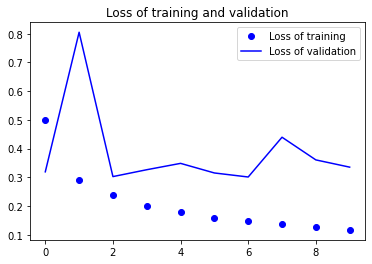

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Accuracy of training')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Accuracy of training and validation')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Loss of training')
plt.plot(epochs, val_loss, 'b', label='Loss of validation')
plt.title('Loss of training and validation')
plt.legend()

plt.show()

In [15]:
names = ["Mihhail", "Kadi", "Merli", "Allar", "Olga"]

import random

random.choice(names)

'Merli'